In [2]:
%matplotlib notebook

import pandas as pd
import pysal as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
try:
    from panel_FE import panel_ols as pn
except:
    print "panel_FE not available"

panel_FE not available


# Spatial correction in the VC matrix of diff-in-diff regression

In this document, I present the process of introducing a spatial error in the estimation of a diff-in-diff model to evaluate the effect of the announcement of a new train station, as described in Comber & Arribas-Bel (2015).

## Data setup

In [3]:
%%time
db = pd.read_csv('../data/finalData.csv', parse_dates=['DATE'])
db['log_P'] = np.log(db['PRICE'])
db['postT'] = 0
db.loc[db['DATE'].apply(lambda x: x.year) >= 2008, 'postT'] = 1
db['RAILxPOST'] = db['CROSSRAIL'] * db['postT']
db['RAILxTIME'] = db['CROSSRAIL'] * db['TIME']
db['TIMExPLACEBO'] = db['PLACEBO'] * db['TIME']
db['quarter'] = db['DATE'].apply(lambda x: str(x.year)) + '-Q' + db['DATE'].apply(lambda x: str(x.quarter))
q_fe = [col for col in db.columns if (col[0]=='Q' and col[2]=='_')]
# Month
month = pd.get_dummies(db['MONTH']).iloc[:, :-1]
db = db.join(month)
year = pd.get_dummies(db['YEAR']).iloc[:, :-1]
db = db.join(year)
# Quarter interactions
#postQ = db[db['TIME']]
treatedQ = [q for q in q_fe if (int(q[3:]) > 2007)]
for q in treatedQ:
    db['RAILx'+q] = db['CROSSRAIL'] * db[q]
treatedQi = ['RAILx'+i for i in treatedQ]

CPU times: user 15.6 s, sys: 341 ms, total: 15.9 s
Wall time: 16.1 s


In [4]:
name_x = [# Access
          'CBD', 'NR', 'UG', 'AIRPORT', \
          # Context
          'POP', 'INCOME1', 'GREENSPACE', \
          # House
          'FLAT', 'DETACHED', 'TERRACE', 'AGE', 'TENANCY']
name_y = 'log_P'

## Data exploration

Explore the balance of time:

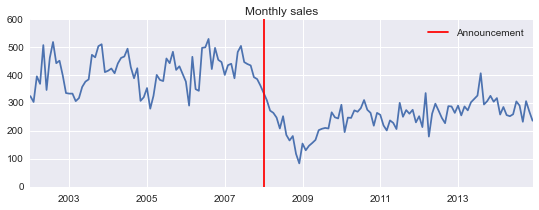

In [4]:
t = pd.Series(np.ones(db.shape[0]), index=pd.DatetimeIndex(db['DATE']))
_ = t.resample('M', 'sum').plot(title='Monthly sales', label='', figsize=(9, 3))
plt.axvline(pd.to_datetime('01/06/2008'), c='red', label='Announcement')
plt.legend()
plt.show()

Average price over time:

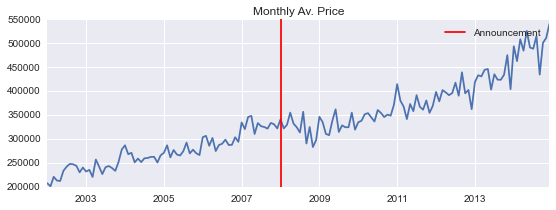

In [5]:
p_t = pd.Series(db['PRICE'].values, pd.DatetimeIndex(db['DATE']))
_ = p_t.resample('M', 'mean').plot(title='Monthly Av. Price', label='', figsize=(9, 3))
plt.axvline(pd.to_datetime('01/06/2008'), c='red', label='Announcement')
plt.legend()
plt.show()

Explore the shape of the buffer:

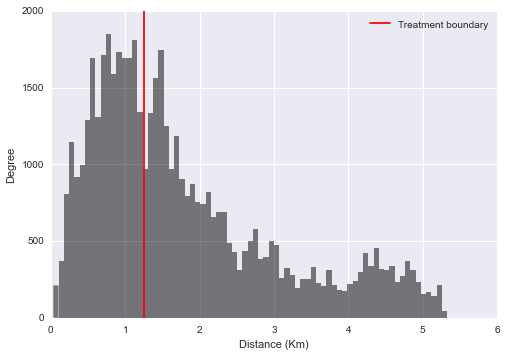

In [6]:
f, ax = plt.subplots(1)
db.CROSSRAIL.plot(kind='hist', bins=75, color='k', \
                         alpha=0.5, linewidth=0, ax=ax, label='')
plt.xlabel('Distance (Km)')
plt.axvline(1.25, c='red', label='Treatment boundary')
plt.legend(frameon=False)
plt.show()

Transactions by quarter:

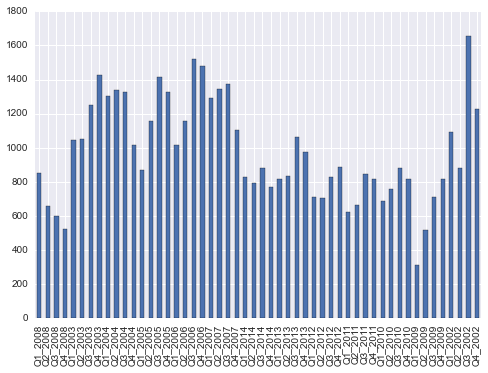

In [7]:
db[q_fe].sum().plot(kind='bar')

In [8]:
#sns.pairplot(db[name_x])
#plt.savefig('/Users/dani/Desktop/matrix_corr.png')

## Non-spatial models

In [24]:
models = []

### Cross-section

Standard cross section regression.

* Weights

In [25]:
%%time
np.random.seed(1234)
db['EAST_jit'] = db['EAST'] + np.random.normal(0, db['EAST'].std()*0.000001, size=db.shape[0])
db['NORTH_jit'] = db['NORTH'] + np.random.normal(0, db['NORTH'].std()*0.000001, size=db.shape[0])
w = ps.knnW_from_array(db[['EAST_jit', 'NORTH_jit']].values, k=15)
w.transform = 'R'

CPU times: user 1.18 s, sys: 39.7 ms, total: 1.22 s
Wall time: 1.23 s


In [26]:
db[['EAST', 'EAST_jit', 'NORTH', 'NORTH_jit']].to_csv('/Users/dani/Desktop/xys.csv')

* Non-spatial

In [27]:
X = ['CROSSRAIL'] + name_x
cs = ps.spreg.OLS(db[[name_y]].values, db[X].values, \
                    name_y=name_y, name_x=X, robust='white', \
                   w=w, spat_diag=True)
models.append(cs)
print did1.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          14
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50849
R-squared           :      0.6206
Adjusted R-squared  :      0.6205
Sum squared residual:    5323.771                F-statistic           :   6398.3432
Sigma-square        :       0.105                Prob(F-statistic)     :           0
S.E. of regression  :       0.324                Log likelihood        :  -14773.747
Sigma-square ML     :       0.105                Akaike info criterion :   29575.495
S.E of regression ML:      0.3235                Schwarz criterion     :   29699.211

White Standard Errors
-------------------------------------------------------

* Spatial

In [28]:
X = ['CROSSRAIL'] + name_x
spcs = ps.spreg.GM_Error_Het(db[[name_y]].values, db[X].values, \
                    name_y=name_y, name_x=X, \
                   w=w)
models.append(spcs)
print spcs.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          14
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50849
Pseudo R-squared    :      0.6102
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      12.1876289       0.0362046     336.6315991       0.0000000
                 AGE      -0.0554152       0.0091911      -6.0292357       0.00

In [54]:
! pwd

/Users/dani/AAA/Documents/research/u-bham/2015/sam_diss/GIT/sc_dab_ealing/code


In [52]:
res = pd.DataFrame({'OLS': pd.Series(models[0].betas.flatten(), index=models[0].name_x), \
                    'O (p)': pd.Series(np.round(np.array(models[0].t_stat)[:, 1], 2), index=models[0].name_x), \
                    'GM-Het': pd.Series(models[1].betas.flatten(), index=models[1].name_x), \
                    'G (p)': pd.Series(np.round(np.array(models[1].z_stat)[:, 1], 2), index=models[1].name_x)})\
                    [['OLS', 'O (p)', 'GM-Het', 'G (p)']]
res

OLS  O (p)     GM-Het  G (p)
AGE         -0.188475   0.00  -0.055415   0.00
AIRPORT      0.028194   0.00   0.027449   0.00
CBD         -0.032477   0.00  -0.036430   0.00
CONSTANT    12.138971   0.00  12.187629   0.00
CROSSRAIL   -0.040968   0.00  -0.056447   0.00
DETACHED     0.505588   0.00   0.421376   0.00
FLAT        -0.127012   0.00  -0.110064   0.00
GREENSPACE  -0.066056   0.00  -0.085902   0.00
INCOME1      0.014621   0.00   0.012028   0.00
NR          -0.002975   0.25   0.009122   0.19
POP         -0.001055   0.00  -0.000878   0.00
TENANCY      0.409953   0.00   0.471170   0.00
TERRACE     -0.066980   0.00  -0.021453   0.00
UG           0.005996   0.03  -0.011852   0.09
lambda            NaN    NaN   0.665287   0.00

### Pre-Post

This is the standard diff-in-diff using pre-post split and continuous distance, without controlling for quarter effects, only before and after.

In [6]:
X = ['TIME', 'CROSSRAIL', 'RAILxTIME'] + \
    month.columns.values.tolist() + year.columns.values.tolist() + \
    name_x
did1 = ps.spreg.OLS(db[[name_y]].values, db[X].values, \
                    name_y=name_y, name_x=X, robust='white')
models.append(did1)
print did1.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          39
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50824
R-squared           :      0.7157
Adjusted R-squared  :      0.7154
Sum squared residual:    3990.064                F-statistic           :   3366.1880
Sigma-square        :       0.079                Prob(F-statistic)     :           0
S.E. of regression  :       0.280                Log likelihood        :   -7439.951
Sigma-square ML     :       0.078                Akaike info criterion :   14957.902
S.E of regression ML:      0.2801                Schwarz criterion     :   15302.541

White Standard Errors
------------------------------------------------------------------------------------
    

In [50]:
X = ['TIME', 'CROSSRAIL', 'RAILxTIME'] + name_x
did1 = ps.spreg.OLS(db[[name_y]].values, db[X].values, \
                    name_y=name_y, name_x=X, robust='white')
models.append(did1)
print did1.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          16
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50847
R-squared           :      0.6583
Adjusted R-squared  :      0.6582
Sum squared residual:    4795.487                F-statistic           :   6529.2967
Sigma-square        :       0.094                Prob(F-statistic)     :           0
S.E. of regression  :       0.307                Log likelihood        :  -12115.986
Sigma-square ML     :       0.094                Akaike info criterion :   24263.972
S.E of regression ML:      0.3071                Schwarz criterion     :   24405.362

White Standard Errors
------------------------------------------------------------------------------------
    

### Pre-Post | Placebo

This is the standard diff-in-diff for the placebo experiment using pre-post split and continuous distance, without controlling for quarter effects, only before and after.

In [9]:
X = ['TIME', 'PLACEBO', 'TIMExPLACEBO'] + \
    month.columns.values.tolist() + year.columns.values.tolist() + \
    name_x
did1p = ps.spreg.OLS(db[[name_y]].values, db[X].values, \
                    name_y=name_y, name_x=X, robust='white')
models.append(did1p)
print did1p.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          39
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50824
R-squared           :      0.7138
Adjusted R-squared  :      0.7135
Sum squared residual:    4016.738                F-statistic           :   3334.9521
Sigma-square        :       0.079                Prob(F-statistic)     :           0
S.E. of regression  :       0.281                Log likelihood        :   -7609.399
Sigma-square ML     :       0.079                Akaike info criterion :   15296.798
S.E of regression ML:      0.2810                Schwarz criterion     :   15641.437

White Standard Errors
------------------------------------------------------------------------------------
    

In [6]:
X = ['TIME', 'PLACEBO', 'TIMExPLACEBO'] + name_x
did1p = ps.spreg.OLS(db[[name_y]].values, db[X].values, \
                    name_y=name_y, name_x=X, robust='white')
models.append(did1p)
print did1p.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          16
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50847
R-squared           :      0.6548
Adjusted R-squared  :      0.6547
Sum squared residual:    4844.113                F-statistic           :   6429.7256
Sigma-square        :       0.095                Prob(F-statistic)     :           0
S.E. of regression  :       0.309                Log likelihood        :  -12372.566
Sigma-square ML     :       0.095                Akaike info criterion :   24777.131
S.E of regression ML:      0.3086                Schwarz criterion     :   24918.522

White Standard Errors
------------------------------------------------------------------------------------
    

### Pre-Post | Q effects

This is the standard diff-in-diff using pre-post split and continuous distance and controlling for quarter effects. Since quarter effects implies a lot of dummy variables, this needs to be estimated using a transformation rather than including dummy variables. See [here](http://nbviewer.ipython.org/gist/darribas/7805381/panel_FE.ipynb) for an explanation of the technique.

* Dummy implementation

In [10]:
X = q_fe[1:] + ['CROSSRAIL'] + treatedQi + name_x
did2dum = ps.spreg.OLS(db[[name_y]].values, db[X].values, \
                    name_y=name_y, name_x=X, robust='white')
models.append(did2dum)
#print did2dum.summary

/media/dani/baul/code/pysal_darribas/pysal/spreg/diagnostics.py:576: ComplexWarning: Casting complex values to real discards the imaginary part
  ci_result = sqrt(max_eigval / min_eigval)


In [11]:
print did2dum.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          93
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50770
R-squared           :      0.7139
Adjusted R-squared  :      0.7134
Sum squared residual:    4014.103                F-statistic           :   1377.2823
Sigma-square        :       0.079                Prob(F-statistic)     :           0
S.E. of regression  :       0.281                Log likelihood        :   -7592.709
Sigma-square ML     :       0.079                Akaike info criterion :   15371.418
S.E of regression ML:      0.2809                Schwarz criterion     :   16193.249

White Standard Errors
------------------------------------------------------------------------------------
    

In [14]:
dummies = pd.get_dummies(db['quarter']).drop('2002-Q1', axis=1)
X = ['CROSSRAIL'] + treatedQi + name_x
did2dum2 = ps.spreg.OLS(db[[name_y]].values, (db[X].join(dummies)).values, \
                    name_y=name_y, name_x=X+list(dummies.columns), robust='white')

* Demeaning implementation

In [15]:
X = ['CROSSRAIL'] + treatedQi + name_x
did2dem = pn.one_way_fe(db[name_y].values, db[X].values, db['quarter'].values, \
                    name_y=name_y, name_x=X, robust='white')
did2dem.std_err = ps.spreg.diagnostics.se_betas(did2dem)
did2dem.t_stat = ps.spreg.diagnostics.t_stat(did2dem)
did2dem.robust = None
did2dem.title = 'DiD-1'
did2dem.name_ds = 'Ealing'
did2dem.name_w = ''
_ = ps.spreg.summary_output.OLS(did2dem, vm=False, w=None, nonspat_diag=True,
                    spat_diag=False, moran=False, white_test=False)
models.append(did2dem)
#print did2dem.summary

* Comparison of the three approaches

As can be seen, `dum` disagrees with the other two, probably because the dummification in the quarters is not entirely correct.

In [16]:
dem = pd.Series(did2dem.betas.ravel(), index=did2dem.name_x)
dum = pd.Series(did2dum.betas.ravel(), index=did2dum.name_x)
dum2 = pd.Series(did2dum2.betas.ravel(), index=did2dum2.name_x)
df = pd.DataFrame({'dem': dem, 'dum':dum, 'dum2':dum2})
df.drop(q_fe[1:]+list(dummies.columns)).head()

dem        dum       dum2
AGE       -0.155036  -0.154957  -0.155036
AIRPORT   -0.000866  -0.000737  -0.000866
CBD       -0.046418  -0.046310  -0.046418
CONSTANT        NaN  12.684791  12.149112
CROSSRAIL -0.007492  -0.007653  -0.007492

## Spatial models

### Weights creation

To include a spatial error in the diff-in-diff especification, we need to account for the structure of the data we are assuming and incorporate it into the design of the spatial weights matrix. The spatial error model only introduces a spatial process in unobserved variables that are assumed uncorrelated with the observed explanatory ones:

$$
y = X\beta + u \\
u = \lambda W u + \epsilon
$$

To model this into the diff-in-diff setup, we create a spatial weights matrix that incorporates the spatial structure used in the cross-section part of the paper (Section 5.2). To make this formalization of space consistent with the way we model the data in the diff-in-diff section, we create a matrix for the houses sold in every period/quarter and then stack them into one global spatial weights matrix. This ensures there is no connection across periods/quarters. This implies, for example, that two houses located next to each other but sold in different quarter are labeled as neighbors in the cross-section analysis, but will not be so in the followin setup. 

Although we impose the additional time constraints stated above, we do not specify any spatial limit as in distance from the treatment location because that is a delineation drawn by the intervention, but there is no reason to believe that other factors, uncorrelated with the intervention, would not remain spatially connected.

In [13]:
def w_stack(ws, silent_island_warning=False):
    '''
    Generate a weights object, `w`, that stacks every element of `ws`
    in the passed index 
    
    ...
    Arguments
    ---------
    ws                      : list
                              Sequence of `ps.W` objects to be stitched
    silent_island_warning   : boolean
                              Switch to turn off (default on) print statements
                              for every observation with islands
    Returns
    -------
    w                       : W
                              Resulting `ps.W` object
    Notes
    -----
    The resulting `w` contains the original indices, converted to strings if
    necessary and preceded by 'X-', where X is the order of the original `W`
    object in `ws`.
    IMPORTANT: Weights are copied from the original weights object and do not
    have any further check. Make sure you do not pass standardized weights!
    '''
    out_neigh = {}
    out_weigh = {}
    out_ids = []
    for wid, w in enumerate(ws):
        for el in w.neighbors:
            i_id = '%i-%s'%(wid, str(el))
            out_neigh[i_id] = ['%i-%s'%(wid, str(j)) \
                                            for j in w.neighbors[el]]
            out_weigh[i_id] = []
            out_weigh[i_id].extend(w.weights[el])
        wids = ['%i-%s'%(wid, str(j)) for j in w.id_order]
        out_ids.extend(wids)
    outW = ps.W(out_neigh, out_weigh, id_order=out_ids, \
            silent_island_warning=silent_island_warning)
    return outW

Introduce some noise to remove co-locations:

In [14]:
import copy
np.random.seed(1234)
db_jig = copy.deepcopy(db)
db_jig['EAST'] = db_jig['EAST'] + np.random.normal(scale=db_jig['EAST']*0.00001)
db_jig['NORTH'] = db_jig['NORTH'] + np.random.normal(scale=db_jig['EAST']*0.00001)

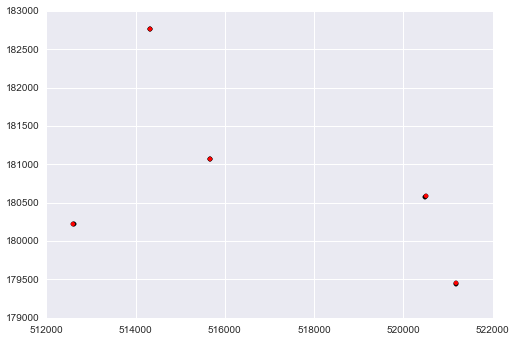

In [15]:
db[['EAST', 'NORTH']].join(db_jig[['EAST', 'NORTH']], rsuffix='_jig').head()
plt.scatter(db.EAST.head(), db.NORTH.head(), c='k')
plt.scatter(db_jig.EAST.head(), db_jig.NORTH.head(), c='red')

* **KNN weights**

In [16]:
%%time
# Pre/post
knn_ws = []
for id, df in db_jig.groupby('TIME'):
    print("Building for time: %s (%i observations)"%(str(id), df.shape[0]))
    w = ps.knnW_from_array(df[['EAST', 'NORTH']], k=15)
    knn_ws.append(w)
knn_wPP = w_stack(knn_ws)
knn_wPP.transform = 'R'

Building for time: 0 (31405 observations)
Building for time: 1 (19458 observations)
CPU times: user 1.36 s, sys: 36 ms, total: 1.4 s
Wall time: 1.38 s


In [17]:
%%time
# By quarter
knn_wsQ = []
for id, df in db_jig.groupby('quarter'):
    w = ps.knnW_from_array(df[['EAST', 'NORTH']], k=15)
    knn_wsQ.append(w)
knn_wQ = w_stack(knn_wsQ)
knn_wQ.transform = 'R'

CPU times: user 1.65 s, sys: 8 ms, total: 1.66 s
Wall time: 1.66 s


* **[DEPRECATED]** Clipping

In [22]:
'''
%%time
xy = db[['X', 'Y']].values
w_time = ps.weights.block_weights(db['quarter'])
# Binary weights
w_dist_b = ps.weights.threshold_binaryW_from_array(xy, ps.weights.min_threshold_distance(xy))
w_bin = ps.weights.Wsets.w_clip(w_dist_b, w_time, outSP=False)
w_bin.transform = 'R'
# Continuous weights
w_dist_c = ps.weights.threshold_continuousW_from_array(xy, ps.weights.min_threshold_distance(xy))
w_con = ps.weights.Wsets.w_clip(w_dist_c, w_time, outSP=False)
w_con.transform = 'R'
'''

"\n%%time\nxy = db[['X', 'Y']].values\nw_time = ps.weights.block_weights(db['quarter'])\n# Binary weights\nw_dist_b = ps.weights.threshold_binaryW_from_array(xy, ps.weights.min_threshold_distance(xy))\nw_bin = ps.weights.Wsets.w_clip(w_dist_b, w_time, outSP=False)\nw_bin.transform = 'R'\n# Continuous weights\nw_dist_c = ps.weights.threshold_continuousW_from_array(xy, ps.weights.min_threshold_distance(xy))\nw_con = ps.weights.Wsets.w_clip(w_dist_c, w_time, outSP=False)\nw_con.transform = 'R'\n"

* **Continuous weights**

In [18]:
%%time
# Pre/post
dis_ws = []
for id, df in db_jig.groupby('TIME'):
    xy = df[['EAST', 'NORTH']].values
    thr = ps.weights.min_threshold_distance(xy)
    w = ps.threshold_continuousW_from_array(xy, thr)
    dis_ws.append(w)
dis_wPP = w_stack(dis_ws)
dis_wPP.transform = 'R'

CPU times: user 4min 4s, sys: 2.31 s, total: 4min 6s
Wall time: 4min 3s


In [19]:
%%time
# By quarter
dis_wsQ = []
for id, df in db_jig.groupby('quarter'):
    xy = df[['EAST', 'NORTH']].values
    thr = ps.weights.min_threshold_distance(xy)
    w = ps.threshold_continuousW_from_array(xy, thr+thr*0.0000001)
    dis_wsQ.append(w)
dis_wQ = w_stack(dis_wsQ)
dis_wQ.transform = 'R'

CPU times: user 23.2 s, sys: 160 ms, total: 23.4 s
Wall time: 23.3 s


### Spatial diff-in-diff

* **KNN | Pre-Post**

In [23]:
%%time
X = ['TIME', 'CROSSRAIL', 'RAILxTIME'] + \
    month.columns.values.tolist() + year.columns.values.tolist() + \
    name_x
did3 = ps.spreg.GM_Error_Het(db[[name_y]].values, db[X].values, \
                   w=knn_wPP, name_y=name_y, name_x=X)
models.append(did3)
#print did3.summary

CPU times: user 3.1 s, sys: 1.09 s, total: 4.19 s
Wall time: 2.91 s


In [24]:
print did3.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          39
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50824
Pseudo R-squared    :      0.7157
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      13.1105855       0.0289182     453.3677363       0.0000000
                2002      -0.8495194       0.0160929     -52.7884293       0.00

In [20]:
%%time
X = ['TIME', 'CROSSRAIL', 'RAILxTIME'] + name_x
did3 = ps.spreg.GM_Error_Het(db[[name_y]].values, db[X].values, \
                   w=knn_wPP, name_y=name_y, name_x=X)
models.append(did3)
#print did3.summary

CPU times: user 6.66 s, sys: 984 ms, total: 7.65 s
Wall time: 6.62 s


In [21]:
print did3.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          16
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50847
Pseudo R-squared    :      0.6582
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      12.1684299       0.0189375     642.5558388       0.0000000
                 AGE      -0.1738158       0.0075955     -22.8839105       0.00

* **KNN | Pre-Post Placebo**

In [25]:
X = ['TIME', 'PLACEBO', 'TIMExPLACEBO'] + \
    month.columns.values.tolist() + year.columns.values.tolist() + \
    name_x
did1p = ps.spreg.GM_Error_Het(db[[name_y]].values, db[X].values, \
                    name_y=name_y, name_x=X, w=knn_wPP)
models.append(did1p)
print did1p.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          39
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50824
Pseudo R-squared    :      0.7138
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      13.1852293       0.0274458     480.4094877       0.0000000
                2002      -0.8684376       0.0157805     -55.0321711       0.00

In [26]:
X = ['TIME', 'PLACEBO', 'TIMExPLACEBO'] + name_x
did1p = ps.spreg.GM_Error_Het(db[[name_y]].values, db[X].values, \
                    name_y=name_y, name_x=X, w=knn_wPP)
models.append(did1p)
print did1p.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          16
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50847
Pseudo R-squared    :      0.6547
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      12.2294994       0.0188006     650.4842015       0.0000000
                 AGE      -0.1746816       0.0077224     -22.6200212       0.00

* **KNN | Quarter**

Brute dummy way:

In [28]:
%%time
dummies = pd.get_dummies(db['quarter']).drop('2002-Q1', axis=1)
X = ['CROSSRAIL'] + treatedQi + name_x
did4dum2 = ps.spreg.GM_Error_Het(db[[name_y]].values, (db[X].join(dummies)).values, \
                    name_y=name_y, name_x=X+list(dummies.columns), \
                    w=knn_wPP)
#print(did4dum2.summary)

CPU times: user 3.46 s, sys: 1.57 s, total: 5.04 s
Wall time: 2.83 s


In [29]:
print(did4dum2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          93
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50770
Pseudo R-squared    :      0.7150
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      12.1490324       0.0219081     554.5446707       0.0000000
             2002-Q2       0.0472883       0.0124972       3.7839081       0.00

* **Distance | Pre-Post**

In [27]:
%%time
X = ['TIME', 'CROSSRAIL', 'RAILxTIME'] + \
    month.columns.values.tolist() + year.columns.values.tolist() + \
    name_x
did5 = ps.spreg.GM_Error_Het(db[[name_y]].values, db[X].values, \
                   w=dis_wPP, name_y=name_y, name_x=X)
models.append(did5)
print did5.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          39
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50824
Pseudo R-squared    :      0.7157
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      13.1102314       0.0289105     453.4760070       0.0000000
                2002      -0.8491989       0.0160909     -52.7752469       0.00

In [30]:
%%time
X = ['TIME', 'CROSSRAIL', 'RAILxTIME'] + name_x
did5 = ps.spreg.GM_Error_Het(db[[name_y]].values, db[X].values, \
                   w=dis_wPP, name_y=name_y, name_x=X)
models.append(did5)
print did5.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       log_P                Number of Observations:       50863
Mean dependent var  :     12.5258                Number of Variables   :          16
S.D. dependent var  :      0.5253                Degrees of Freedom    :       50847
Pseudo R-squared    :      0.6578
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      12.1644700       0.0191961     633.6947081       0.0000000
                 AGE      -0.1742382       0.0075777     -22.9936471       0.00

* **Distance | Quarter**

## Summary

**NOTE**: not implemented.

In [31]:
models

[<pysal.spreg.ols.OLS instance at 0x7f3021bcb7e8>,
 <pysal.spreg.ols.OLS instance at 0x7f3021b967e8>,
 <pysal.spreg.ols.OLS instance at 0x7f3021bbe200>,
 <pysal.spreg.ols.BaseOLS instance at 0x7f301e0cd320>,
 <pysal.spreg.error_sp_het.GM_Error_Het instance at 0x7f2f4106cef0>,
 <pysal.spreg.error_sp_het.GM_Error_Het instance at 0x7f2f40c7ac68>,
 <pysal.spreg.error_sp_het.GM_Error_Het instance at 0x7f2f40c84d40>]

In [32]:
ms = {'OLS-PP': models[0], 'OLS-Q': models[1], \
      'GM - KNN | PP': models[4], \
      'GM - Dis | PP': models[5]}

In [33]:
mn = {0: 'OLS-Con', 1: 'OLS-Bin', 2: 'GMM-Con', 3: 'GMM-Bin'}
mn = {0: 'OLS-Pool', 1: 'OLS-Q', 2: 'OLS-Q (Placebo)'}
order = ['CROSSRAIL', 'RAILxPOST', 'PLACEBO', 'RAILxPLACEBO', 'TIME', 'CONSTANT'] + name_x + ['lambda']
#res = [pd.DataFrame({(mn[i], 'Beta'): model.betas.ravel(), (mn[i], 'Std. Err.'): model.std_err.ravel()}, model.name_x) \
#      for i,model in enumerate(models)]
res = [pd.DataFrame({(ms[i], 'Beta'): ms[i].betas.ravel(), \
                     (ms[i], 'P-Val'): np.array(ms[i].t_stat)[:, 1]}, ms[i].name_x) \
      for i in ms]
res = pd.concat(res, axis=1)
res.reindex(order).fillna('')

AttributeError: GM_Error_Het instance has no attribute 't_stat'